In [1]:
import pandas as pd
import pickle

df = pd.read_csv('..\data\processed\phishing.csv')
df.head()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [2]:
# Importing module and initializing setup
from pycaret.classification import *

In [3]:
originaldata = setup(data = df, target = 'Result')

,Description,Value
0,Session id,8277
1,Target,Result
2,Target type,Binary
3,Target mapping,"-1: 0, 1: 1"
4,Original data shape,"(11055, 31)"
5,Transformed data shape,"(11055, 31)"
6,Transformed train set shape,"(7738, 31)"
7,Transformed test set shape,"(3317, 31)"
8,Numeric features,30
9,Preprocess,True


In [4]:
#compare the Best Model
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9712,0.9951,0.9712,0.9713,0.9711,0.9415,0.9417,0.3340
et,Extra Trees Classifier,0.9701,0.9916,0.9701,0.9703,0.9701,0.9395,0.9396,0.3390
lightgbm,Light Gradient Boosting Machine,0.9686,0.9958,0.9686,0.9687,0.9686,0.9363,0.9364,0.7010
dt,Decision Tree Classifier,0.9586,0.9701,0.9586,0.9588,0.9586,0.9162,0.9164,0.0550
gbc,Gradient Boosting Classifier,0.9465,0.9898,0.9465,0.9466,0.9464,0.8913,0.8916,0.5700
knn,K Neighbors Classifier,0.9350,0.9796,0.9350,0.9351,0.9349,0.8681,0.8683,0.1720
ada,Ada Boost Classifier,0.9347,0.9864,0.9347,0.9350,0.9346,0.8673,0.8678,0.2710
lr,Logistic Regression,0.9256,0.9778,0.9256,0.9257,0.9254,0.8488,0.8491,0.9980
svm,SVM - Linear Kernel,0.9228,0.9758,0.9228,0.9234,0.9227,0.8433,0.8441,0.0690
ridge,Ridge Classifier,0.9192,0.9735,0.9192,0.9196,0.9190,0.8356,0.8363,0.0370


Model : et


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9774,0.9988,0.9774,0.9775,0.9774,0.9543,0.9543
1,0.9581,0.9930,0.9581,0.9581,0.9580,0.9149,0.9149
2,0.9548,0.9780,0.9548,0.9550,0.9549,0.9086,0.9087
3,0.9581,0.9897,0.9581,0.9581,0.9580,0.9148,0.9150
4,0.9806,0.9908,0.9806,0.9806,0.9806,0.9608,0.9608
5,0.9742,0.9903,0.9742,0.9750,0.9742,0.9479,0.9486
6,0.9710,0.9892,0.9710,0.9710,0.9710,0.9412,0.9412
7,0.9710,0.9823,0.9710,0.9711,0.9709,0.9410,0.9412
8,0.9871,0.9949,0.9871,0.9871,0.9871,0.9738,0.9738


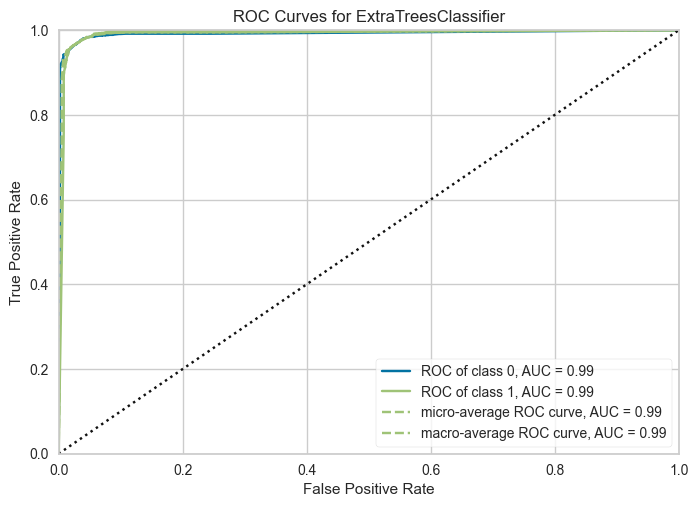

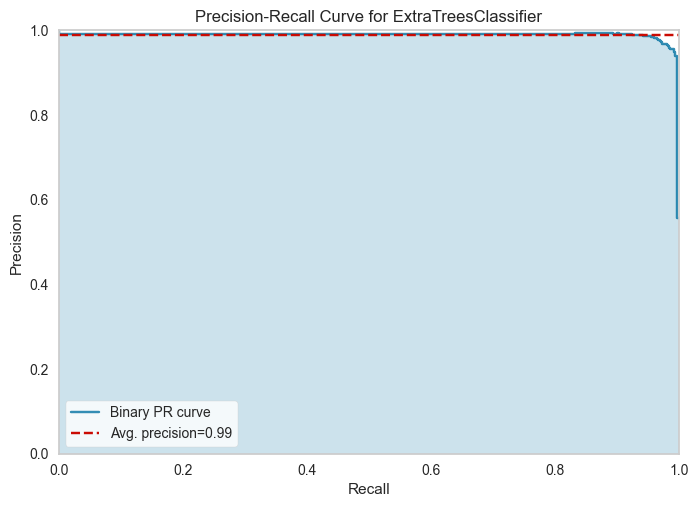

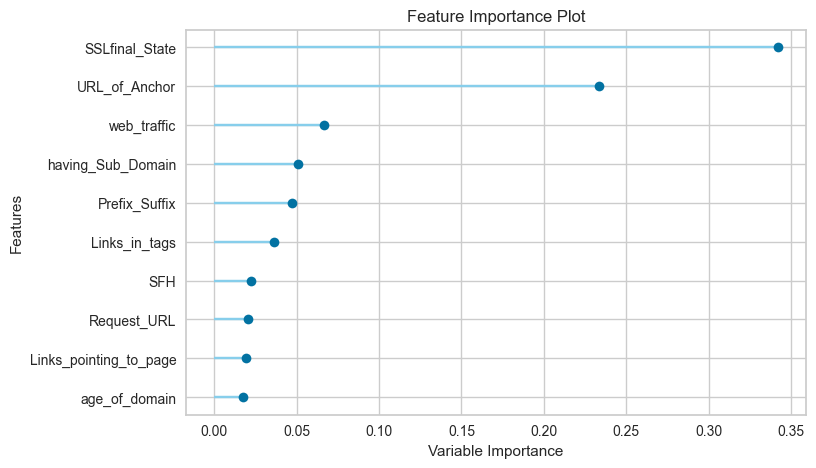

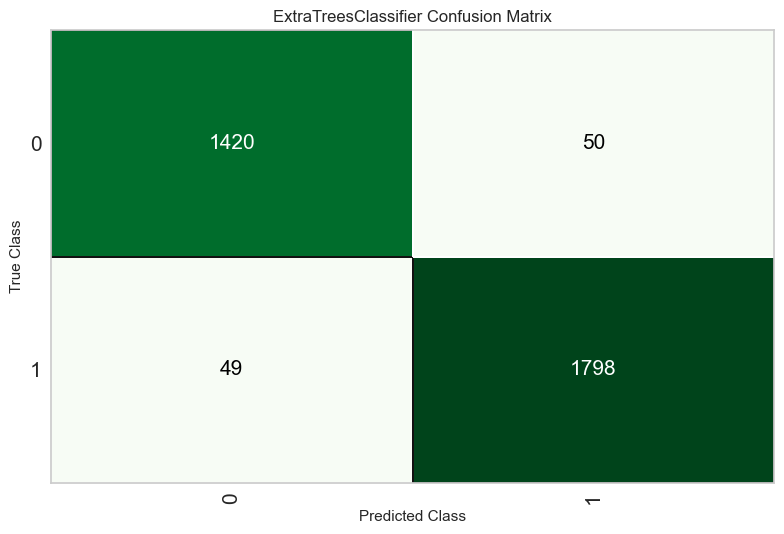

__________________________________________________
Model : rf


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9839,0.9988,0.9839,0.9839,0.9839,0.9673,0.9673
1,0.9613,0.9912,0.9613,0.9615,0.9612,0.9213,0.9216
2,0.9516,0.9890,0.9516,0.9516,0.9516,0.9018,0.9018
3,0.9710,0.9922,0.9710,0.9711,0.9709,0.9410,0.9412
4,0.9774,0.9970,0.9774,0.9775,0.9774,0.9543,0.9543
5,0.9677,0.9953,0.9677,0.9686,0.9678,0.9349,0.9356
6,0.9806,0.9947,0.9806,0.9807,0.9806,0.9607,0.9608
7,0.9710,0.9942,0.9710,0.9714,0.9709,0.9409,0.9414
8,0.9871,0.9940,0.9871,0.9871,0.9871,0.9738,0.9738


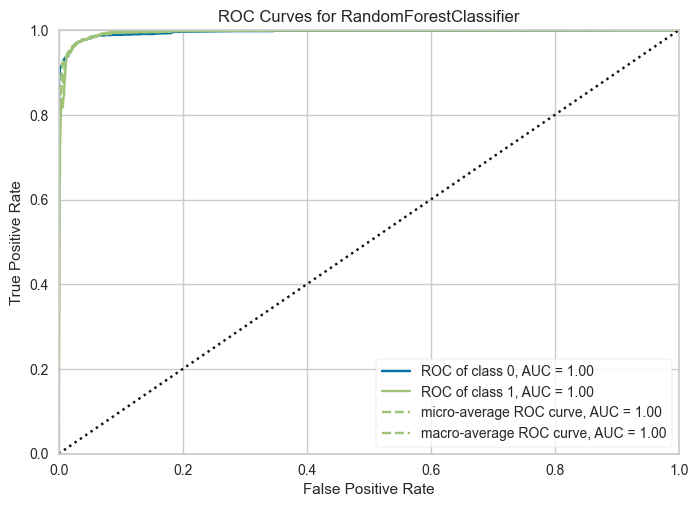

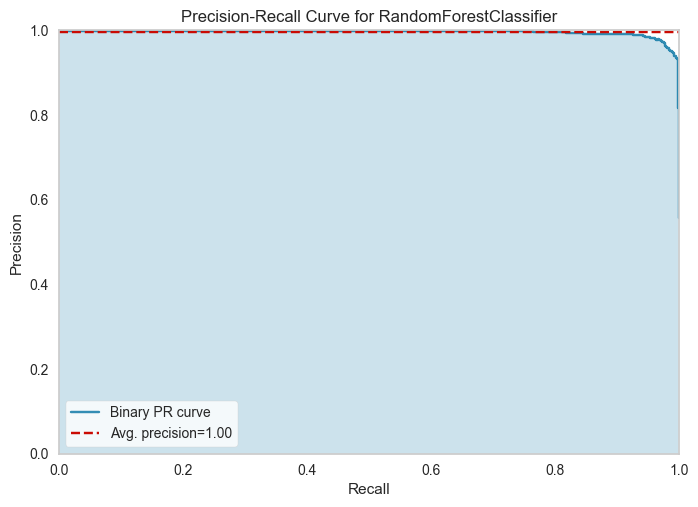

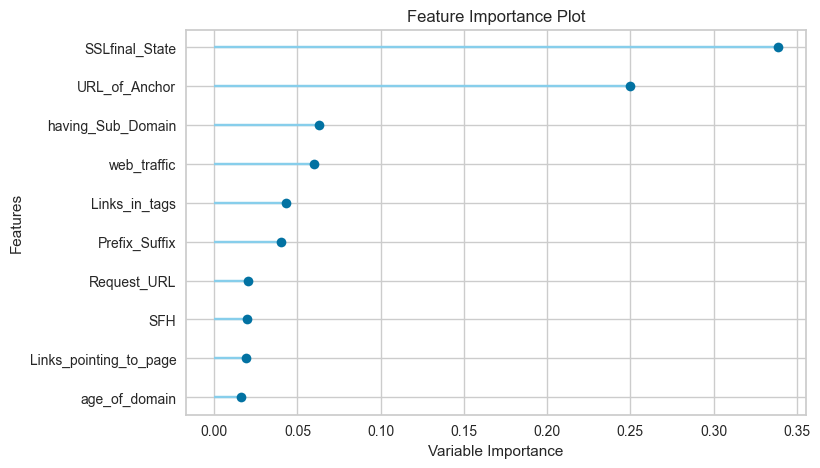

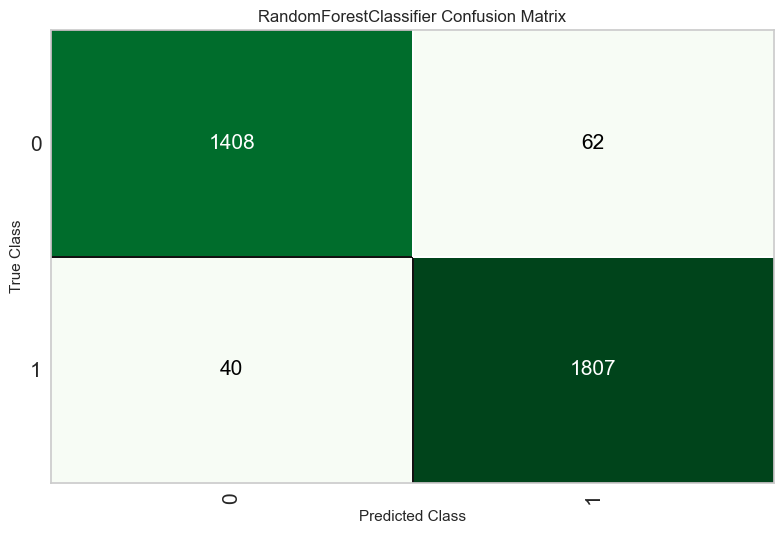

__________________________________________________
Model : lightgbm


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9806,0.9986,0.9806,0.9808,0.9807,0.9608,0.9609
1,0.9581,0.9939,0.9581,0.9581,0.9580,0.9148,0.9150
2,0.9452,0.9922,0.9452,0.9452,0.9451,0.8886,0.8887
3,0.9581,0.9961,0.9581,0.9581,0.9580,0.9149,0.9149
4,0.9806,0.9986,0.9806,0.9806,0.9806,0.9608,0.9608
5,0.9806,0.9981,0.9806,0.9806,0.9806,0.9608,0.9608
6,0.9710,0.9968,0.9710,0.9712,0.9710,0.9413,0.9415
7,0.9774,0.9972,0.9774,0.9775,0.9774,0.9541,0.9543
8,0.9806,0.9987,0.9806,0.9808,0.9807,0.9608,0.9609


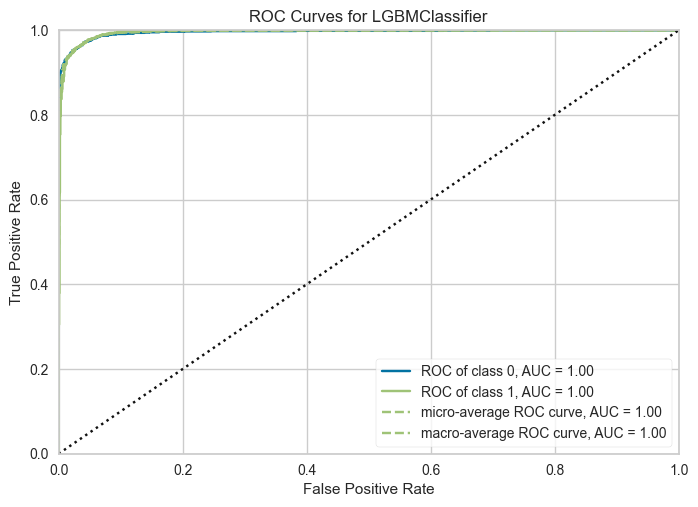

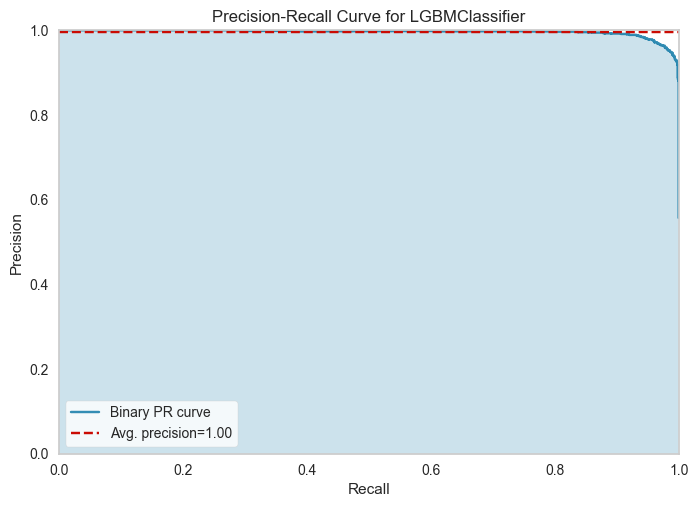

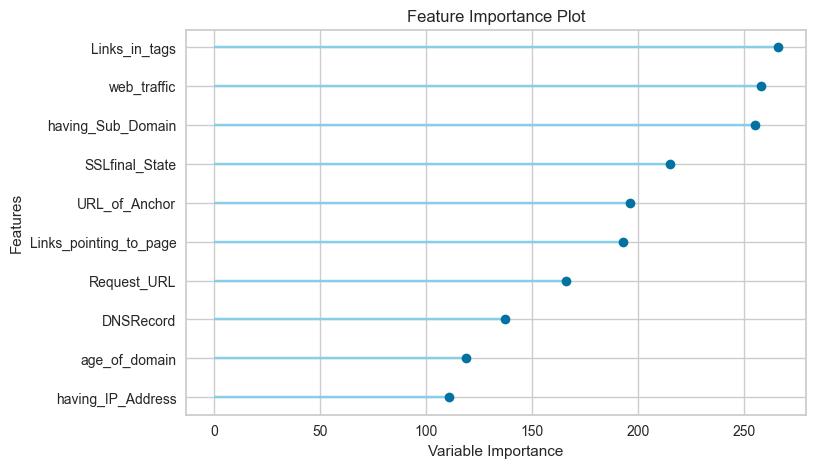

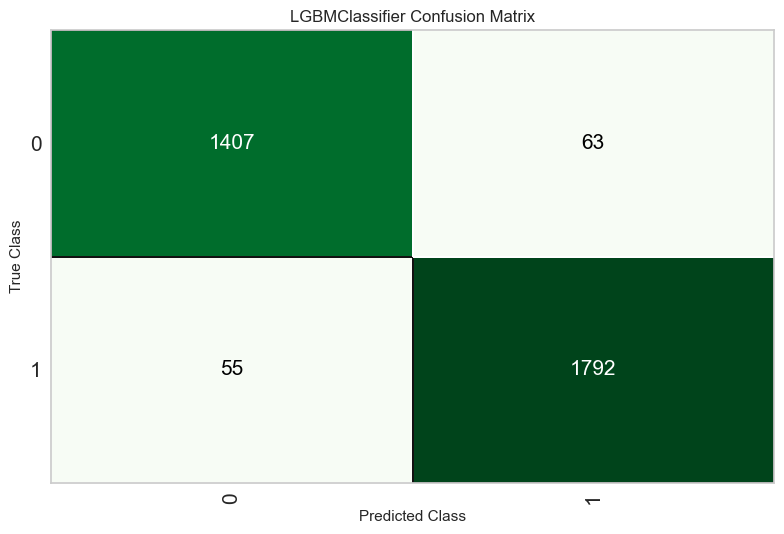

__________________________________________________
Model : dt


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9710,0.9823,0.9710,0.9710,0.9710,0.9411,0.9411
1,0.9452,0.9615,0.9452,0.9452,0.9452,0.8889,0.8889
2,0.9548,0.9664,0.9548,0.9550,0.9549,0.9086,0.9087
3,0.9677,0.9740,0.9677,0.9677,0.9677,0.9346,0.9346
4,0.9613,0.9696,0.9613,0.9613,0.9613,0.9215,0.9215
5,0.9419,0.9601,0.9419,0.9435,0.9421,0.8830,0.8842
6,0.9581,0.9728,0.9581,0.9581,0.9581,0.9150,0.9151
7,0.9677,0.9726,0.9677,0.9678,0.9677,0.9345,0.9346
8,0.9806,0.9867,0.9806,0.9808,0.9807,0.9608,0.9609


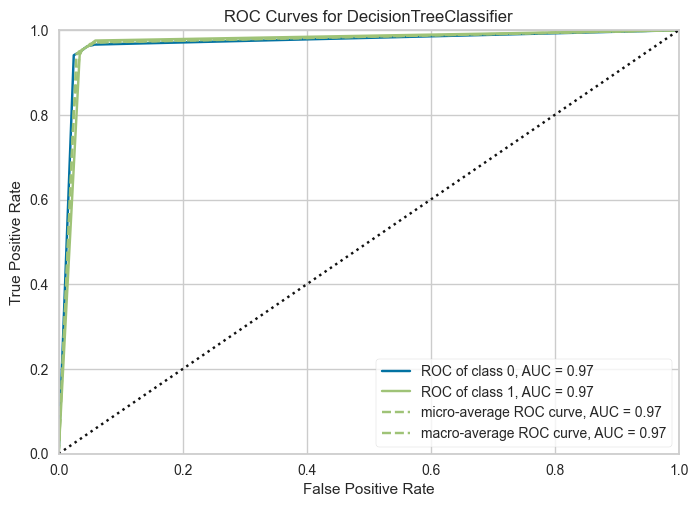

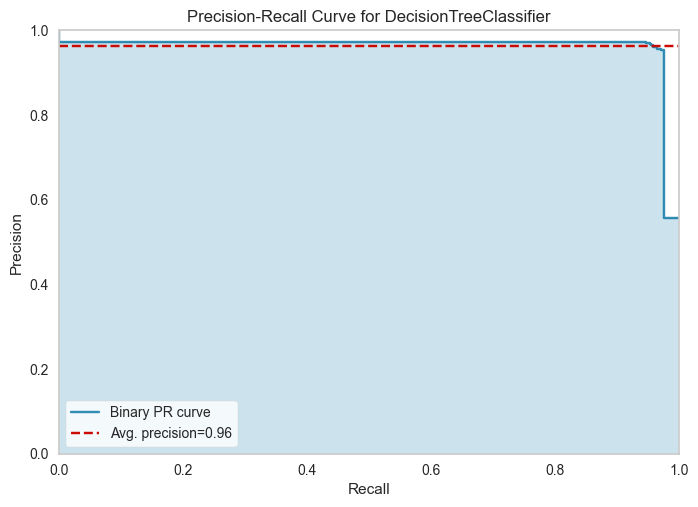

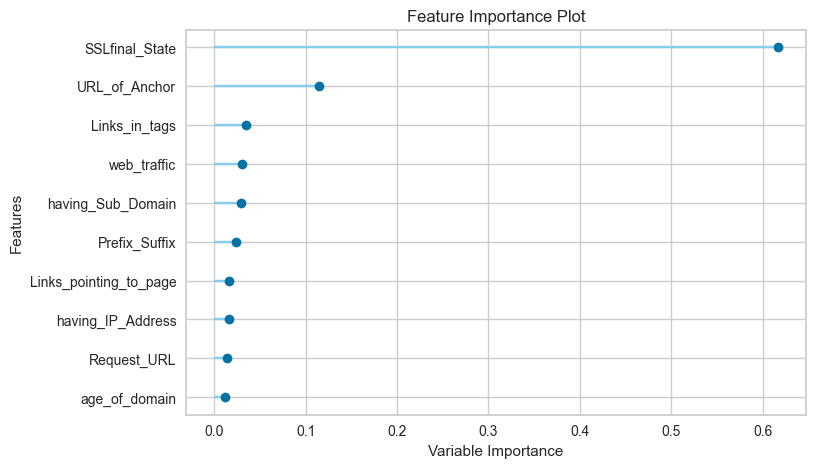

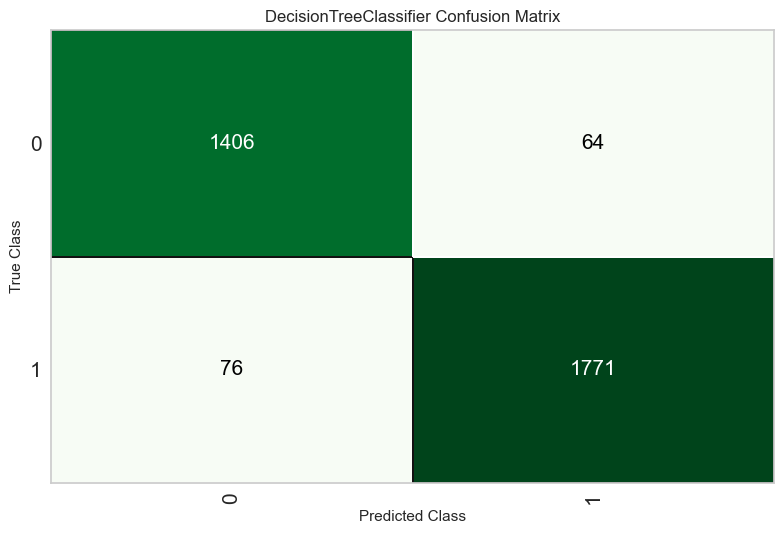

__________________________________________________
Model : gbc


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9613,0.9930,0.9613,0.9613,0.9613,0.9214,0.9215
1,0.9258,0.9889,0.9258,0.9263,0.9256,0.8488,0.8497
2,0.9355,0.9837,0.9355,0.9355,0.9354,0.8690,0.8691
3,0.9452,0.9916,0.9452,0.9452,0.9451,0.8886,0.8887
4,0.9677,0.9952,0.9677,0.9677,0.9677,0.9346,0.9346
5,0.9516,0.9920,0.9516,0.9517,0.9516,0.9020,0.9020
6,0.9484,0.9930,0.9484,0.9485,0.9484,0.8955,0.8956
7,0.9452,0.9899,0.9452,0.9470,0.9449,0.8879,0.8902
8,0.9645,0.9946,0.9645,0.9646,0.9645,0.9281,0.9281


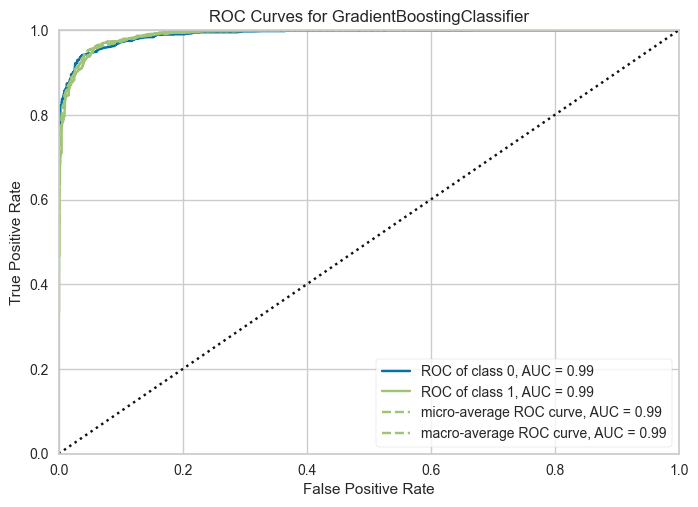

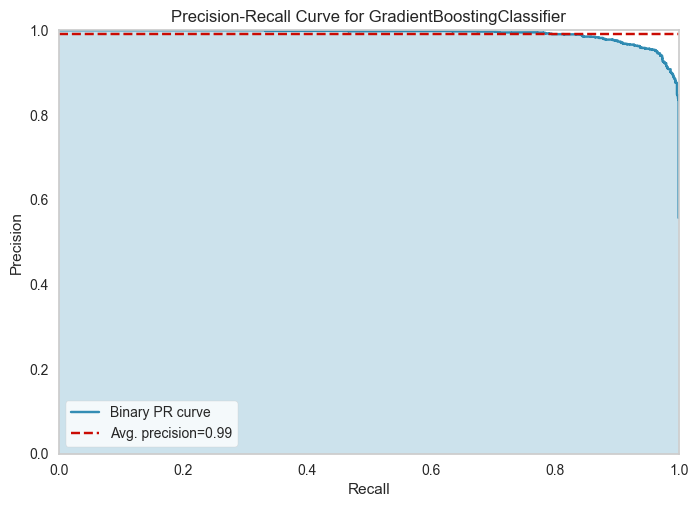

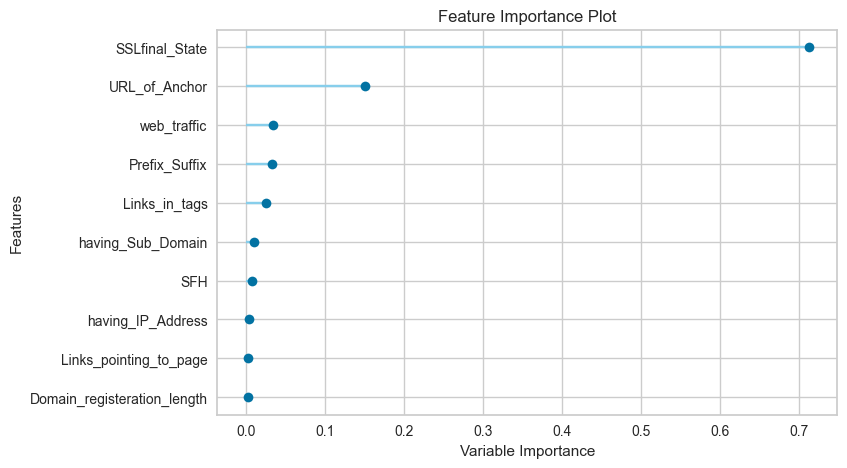

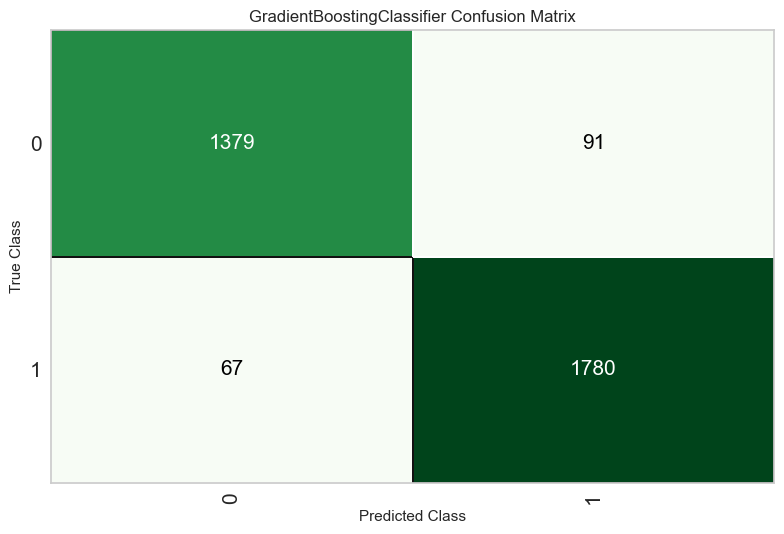

__________________________________________________


In [5]:
import os 

model_folder = os.path.join('..', 'models')
os.makedirs(model_folder, exist_ok=True) 

models = ['et', 'rf', 'lightgbm', 'dt', 'gbc']

def train_model(models):
    for model in models:
        print(f"Model : {model}")
        # train rf model using 25 fold CV
        classifier_model = create_model(model, fold = 25)
        plot_model(classifier_model, plot = 'auc')
        plot_model(classifier_model, plot = 'pr')
        plot_model(classifier_model, plot = 'feature')
        plot_model(classifier_model, plot = 'confusion_matrix')

        # save_model(classifier_model, os.path.join('..'. 'models', model+'_model'))
        with open(os.path.join('..', 'models', model+'_model.pkl'), 'wb') as files:
            pickle.dump(classifier_model, files)
        
        print('_'*50)

train_model(models)

In [7]:
import glob
import joblib
import pickle
import numpy as np
from collections import Counter

def load_model(pkl_file_path):
    with open(pkl_file_path, 'rb') as file:
        model = pickle.load(file)
        # model = joblib.load(pkl_file_path)
    return model

def predict_with_model(model, input_data, class_names):
    # Make a prediction
    # predicted_output = model.predict([input_data])
    predicted_proba = model.predict_proba([input_data])[0]
    predicted_class_index = np.argmax(predicted_proba)
    predicted_class_name = class_names[predicted_class_index]
    predicted_class_probability = predicted_proba[predicted_class_index]

    return {
        "class_name": predicted_class_name,
        "probability": predicted_class_probability
    }

def predict_with_voting(class_names, probabilities):
    # Create a Counter object to count occurrences of each element
    element_counter = Counter(class_names)
    
    # Find the element with the maximum count
    most_common_element, count = element_counter.most_common(1)[0]
    
    # Find average of probabilities
    avg_probability = np.mean(probabilities)
    
    return most_common_element, avg_probability

def multimodel_voting(input_data, op_val=None): 
    model_class_names, model_probabilities = [], []
    
    for md in glob.glob(os.path.join('..', 'models', '*')):

        pkl_file_path = md # 'path_to_your_model.pkl'
        class_names = [-1, 1] # ['unsafe', 'safe'] # [-1, 1] # Update with your actual class names

        model = load_model(pkl_file_path)
        result = predict_with_model(model, input_data, class_names)
        model_class_names.append(result['class_name'])
        model_probabilities.append(result['probability'])

        print(result, ' || ',  op_val)
        print('__'*30)

    result_class, result_probability = predict_with_voting(model_class_names, model_probabilities)
    print(result_class, round(result_probability*100, 2))
    
    return result_class, round(result_probability*100, 2)
    
if __name__ == '__main__':
    
    df = pd.read_csv('..\data\processed\phishing.csv')
    input_df_copy = df.copy().drop('Result', axis = 1)
    input_df = input_df_copy.sample(n=10)
    input_df = input_df.reset_index(drop=True)
    # display(input_df)
    
    result_op, prob_op = [], []
    for index in range(len(input_df)):
        res, prob = multimodel_voting(input_df.iloc[index, :], op_val=None)
        result_op.append(res) 
        prob_op.append(prob)
        print('\n')
    
    input_df['prediction'] = result_op
    input_df['probability'] = prob_op
    display(input_df)

{'class_name': -1, 'probability': 1.0}  ||  None
____________________________________________________________
{'class_name': -1, 'probability': 1.0}  ||  None
____________________________________________________________
{'class_name': -1, 'probability': 0.9957459316806144}  ||  None
____________________________________________________________
{'class_name': -1, 'probability': 0.9998344578051607}  ||  None
____________________________________________________________
{'class_name': -1, 'probability': 1.0}  ||  None
____________________________________________________________
-1 99.91


{'class_name': -1, 'probability': 1.0}  ||  None
____________________________________________________________
{'class_name': -1, 'probability': 0.99}  ||  None
____________________________________________________________
{'class_name': -1, 'probability': 0.9972323490831009}  ||  None
____________________________________________________________
{'class_name': -1, 'probability': 0.9997209893984053}  ||  None

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,prediction,probability
0,-1,-1,1,1,1,-1,-1,0,1,1,...,1,1,1,0,-1,1,1,1,-1,99.91
1,-1,1,1,1,1,-1,0,-1,-1,1,...,1,1,1,-1,-1,1,0,1,-1,99.74
2,1,1,1,1,1,1,-1,1,-1,1,...,1,-1,-1,1,1,1,-1,1,1,99.79
3,-1,-1,1,1,-1,-1,-1,0,1,1,...,1,1,1,0,-1,1,-1,1,-1,98.70
4,1,-1,1,1,1,-1,0,1,-1,1,...,1,-1,1,1,1,1,0,1,1,66.59
5,-1,-1,1,1,1,-1,1,-1,-1,-1,...,1,-1,1,1,-1,1,1,-1,-1,98.21
6,1,-1,1,-1,1,-1,1,1,1,-1,...,-1,-1,1,-1,1,1,0,1,1,98.59
7,1,-1,1,1,1,-1,-1,1,-1,1,...,1,-1,1,0,-1,-1,0,1,-1,94.02
8,1,-1,1,1,1,1,0,1,1,1,...,1,1,-1,1,1,1,1,1,1,99.77
9,-1,1,1,-1,1,-1,1,1,-1,-1,...,1,-1,1,-1,1,1,1,1,1,99.08
